In [2]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, get_extreme_examples, get_aggregated_embeddings_for_each_year

In [3]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [4]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# Partial least squares regression

Identify component in our embeddings which explain our target variable (party affiliation)

In [5]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split


def pls(sample): 
    lb = LabelEncoder()

    X = np.stack(sample[EMBEDDING_MODEL])
    y = lb.fit_transform(sample["block"])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

    # print(f"#Classes {len(lb.classes_)}")

    y_train = np.eye(len(lb.classes_))[y_train]  # create one-hot encodding to use PLS for classification PLS-DA


    pls = PLSRegression(n_components=2)
    pls.fit(X_train, y_train)

    reduced = pls.transform(X)

    r2 = pls.score(X_test, np.eye(len(lb.classes_))[y_test])
    # print(f"PLS r-squared {r2:.3f}")
    return reduced, r2, pls

In [97]:
median_speechnum_p_year_and_party = int(df.groupby(["year", "block"]).size().median())

def sample_from_df(): 
    dfs = []
    for block in df['block'].unique(): 
        for year in df['year'].unique(): 
            s = df[(df['year'] == year) & (df['block'] == block)]
            s = s.sample(median_speechnum_p_year_and_party, replace=True)
            dfs.append(s)
    return pd.concat(dfs)


n_samples = 10000

bootstraps = []

from tqdm import tqdm 

for i in tqdm(range(n_samples)): 
    sample = sample_from_df()
    sample_reduced, r2, sample_pls = pls(sample)
    
    bootstraps.append({
        "sample": sample, 
        "pls": sample_pls, 
        "r2": r2, 
    })

# plt.legend()

# all_r2 = np.array(all_r2)
# all_reduced = np.stack(all_reduced)

 73%|███████▎  | 7251/10000 [11:23<04:19, 10.61it/s] 


KeyboardInterrupt: 

In [100]:
n_samples = len(bootstraps)

In [102]:
from scipy.linalg import orthogonal_procrustes

CORRECT_WEIGHTS = True 
if CORRECT_WEIGHTS: 
    def align_weights(W, W_ref):
        # W, W_ref: (d, k)
        R, _ = orthogonal_procrustes(W, W_ref)
        return W @ R


    W_ref = bootstraps[0]["pls"].x_weights_

    for b in tqdm(bootstraps, "Adjusting weights"):
        W = b["pls"].x_weights_
        W_aligned = align_weights(W, W_ref)
        b["pls_aligned"] = W_aligned
        b["reduced"] = np.stack(b["sample"][EMBEDDING_MODEL]) @ W_aligned
else: 
    for b in tqdm(bootstraps, "Not adjusting weights"):
        W = b["pls"].x_weights_
        b["pls_aligned"] = b["pls"].x_weights_
        b["reduced"] = np.stack(b["sample"][EMBEDDING_MODEL]) @ W


Adjusting weights: 100%|██████████| 7251/7251 [00:44<00:00, 162.84it/s]


In [ ]:
def closest_words_for_pc(k, vocab, reduced_embs, top_n=20):
    sorted_indices = np.argsort(reduced_embs[:, k])

    
    pos_idx = sorted_indices[-top_n:]
    neg_idx = sorted_indices[:top_n]

    def map_indices_to_examples(index_list): 
        if isinstance(vocab, pd.DataFrame) or isinstance(vocab, pd.Series): 
            return [(vocab.iloc[i], reduced_embs[:, k][i]) for i in index_list]
        else:
            return [(vocab[i], reduced_embs[:, k][i]) for i in index_list]

    return map_indices_to_examples(neg_idx),  map_indices_to_examples(pos_idx)

In [136]:
X_full = np.stack(df[EMBEDDING_MODEL])   # (N, d)

years  = df["year"].unique()
blocks = df["block"].unique()

pls_means = np.zeros((n_samples, len(years), len(blocks), 2))
pls_stds  = np.zeros((n_samples, len(years), len(blocks), 2))

year_masks = [df['year'] == y for y in years]
party_masks = [df['block'] == b for b in blocks]

for i, res in tqdm(enumerate(bootstraps), total=n_samples):
    scores = X_full @ res["pls_aligned"]   # (N, 2)
    for y, Y in enumerate(year_masks): 
        for b, B in enumerate(party_masks): 
            s_y_b = scores[Y & B]
            pls_means[i, y, b] = s_y_b.mean(axis=0)
            pls_stds[i, y, b] = s_y_b.std(axis=0)

100%|██████████| 7251/7251 [01:01<00:00, 117.28it/s]


In [147]:
# TODO: make this more efficient; this surely can be done in numpy; would vocab_emb @ pls_models not immediately work?

vocab_emb = np.stack(vocab_df[EMBEDDING_MODEL])
pls_models = np.stack([b["pls_aligned"] for b in bootstraps])
out = np.zeros((pls_models.shape[0], vocab_emb.shape[0], pls_models.shape[-1]))
for b in tqdm(range(pls_models.shape[0])): 
    out[b] = vocab_emb @ pls_models[i]

vocab_reduced = out.mean(axis=0)

100%|██████████| 7251/7251 [01:46<00:00, 67.85it/s]


In [209]:
def plot_axis(axis, ax, plot_stds=False): 
    ax.set_title(f"Development of parties over the years accross reduced-axis {axis}")
    
    axis_labels = closest_words_for_pc(axis, vocab_df['word'], vocab_reduced)
    color_map = COLOR_MAPS['block']

    for b, block in enumerate(blocks):
        mean = pls_means[:, :, b, axis].mean(axis=0)
        ax.plot(years, mean, color=color_map[block], label=block)

        # over the bootstrap runs, the mean PLS scores differ 
        # => what is the std? => how confident are we, that the actual mean score is within the 
        # mean estimate above? 
        mean_std = pls_means[:, :, b, axis].std(axis=0)
        ax.fill_between(years, mean-2*mean_std, mean+2*mean_std, color=color_map[block], alpha=0.3)


        # lo = np.percentile(pls_traj[:, :, b], 5, axis=0)
        # hi = np.percentile(pls_traj[:, :, b], 95, axis=0)

        # TODO: how to plot this: 
        # the scores differ as well within each bootstrap run; above we have computed the mean 
        # but how distributed are the scores within one run acutally? => each run has a std 
        stds = pls_stds[:, :, b, axis]
        # on average, the scores deviate by the mean std: 
        std_mean = stds.mean(axis=0)
        # but over the different runs, the standard again is distributed; => how certain are we about how 
        # distributed the values actually are? => how much variance is there over the different bootstrap runs?  
        std_std = stds.std(axis=0)

        if plot_stds: 
            ax.fill_between(years, mean-std_mean, mean+std_mean, color=color_map[block], alpha=0.3)
        # plt.fill_between(years, mean-std_mean-stds_std, mean+std_mean+stds_std, color=color_map[block], alpha=0.1)

        # plt.fill_between(unique_years, lo, hi, color=color_map[block], alpha=0.2)
        # for run in pls_traj[:, :, b]: 
        #     plt.plot(unique_years, run, color=color_map[block], label=block, alpha=0.2)

    max_y_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
    ax.set_ylim((-max_y_lim, max_y_lim))  
    ax.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:5]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:5]))

    props = dict(boxstyle='round', facecolor="grey", alpha=0.5)

    # label for negative axis: 
    ax.text(2014, -0.8 * max_y_lim , f"{ax_label_neg}", horizontalalignment="left", bbox=props)
    # label for positive axis: 
    ax.text(2014, 0.8 * max_y_lim, f"{ax_label_pos}", horizontalalignment="left", bbox=props)
    ax.grid()

    # ax.legend()
    ax.set_xlabel("Year")
    ax.set_ylabel(f"PLS axis {axis}")
    
    # plt.tight_layout()

In [210]:
# def plot_aggregated_yearly_data(ax):
# ax 
def plot_scatter(ax): 
    ax.set_title("Two Dimensional Projection of Political Groups")

    grt = np.abs(pls_means).max() * 1.1

    ax.set_xlim(-grt, grt)
    ax.set_ylim(-grt, grt)

    scale = grt * 2


    color_map = COLOR_MAPS['block']

    for b, block in enumerate(blocks):
        mean_scores = pls_means[:, :, b].mean(axis=0)
        ax.scatter(mean_scores[:, 0], mean_scores[:, 1], marker='o', color=color_map[block], label=block)

        for i, year in enumerate(years):
            ax.text(mean_scores[i, 0] - scale * 0.01, mean_scores[i, 1]+ scale * 0.015, f"{year}",
                fontsize=8, bbox=dict(boxstyle="round", color=color_map[block], alpha=0.7), 
                color='white',
            )

    ax.axhline(0, linestyle="--")
    ax.axvline(0, linestyle="--")
    ax.grid()
    ax.legend(loc="upper left")
    # return ax

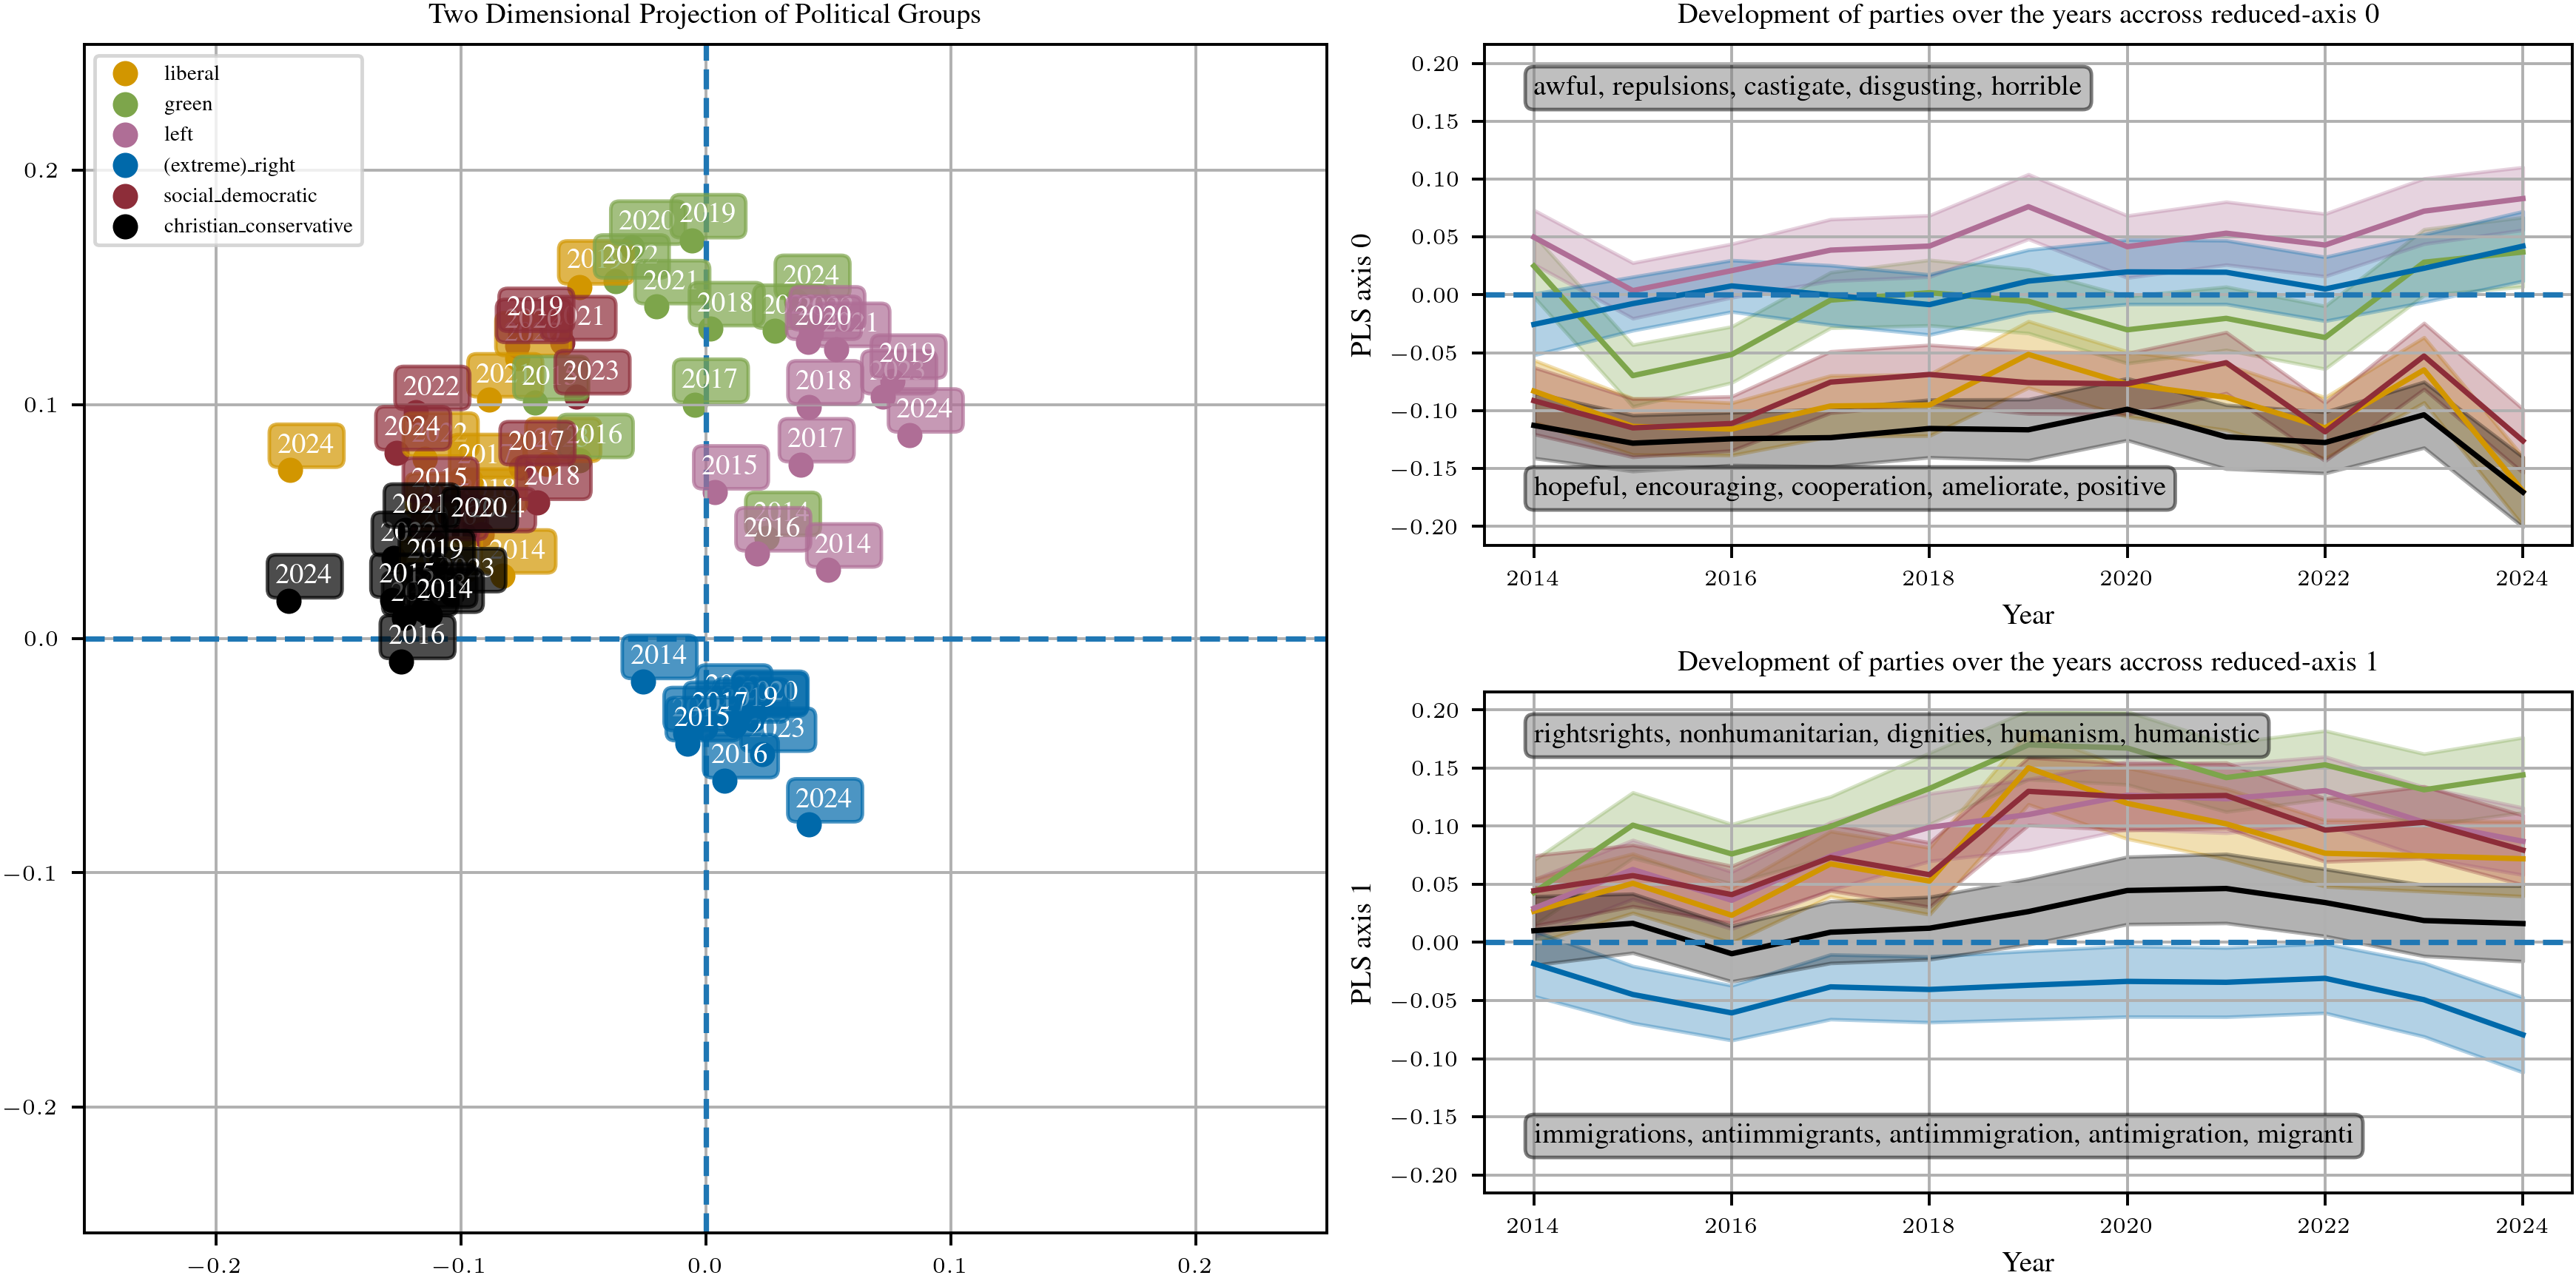

In [211]:
fig = plt.figure(layout="constrained", figsize=(10, 5))

gs0 = fig.add_gridspec(1, 2)
gs1 = gs0[1].subgridspec(2, 1)

ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs1[0])
ax3 = fig.add_subplot(gs1[1], sharex=ax2)

plot_scatter(ax1)
plot_axis(0, ax2)
plot_axis(1, ax3)

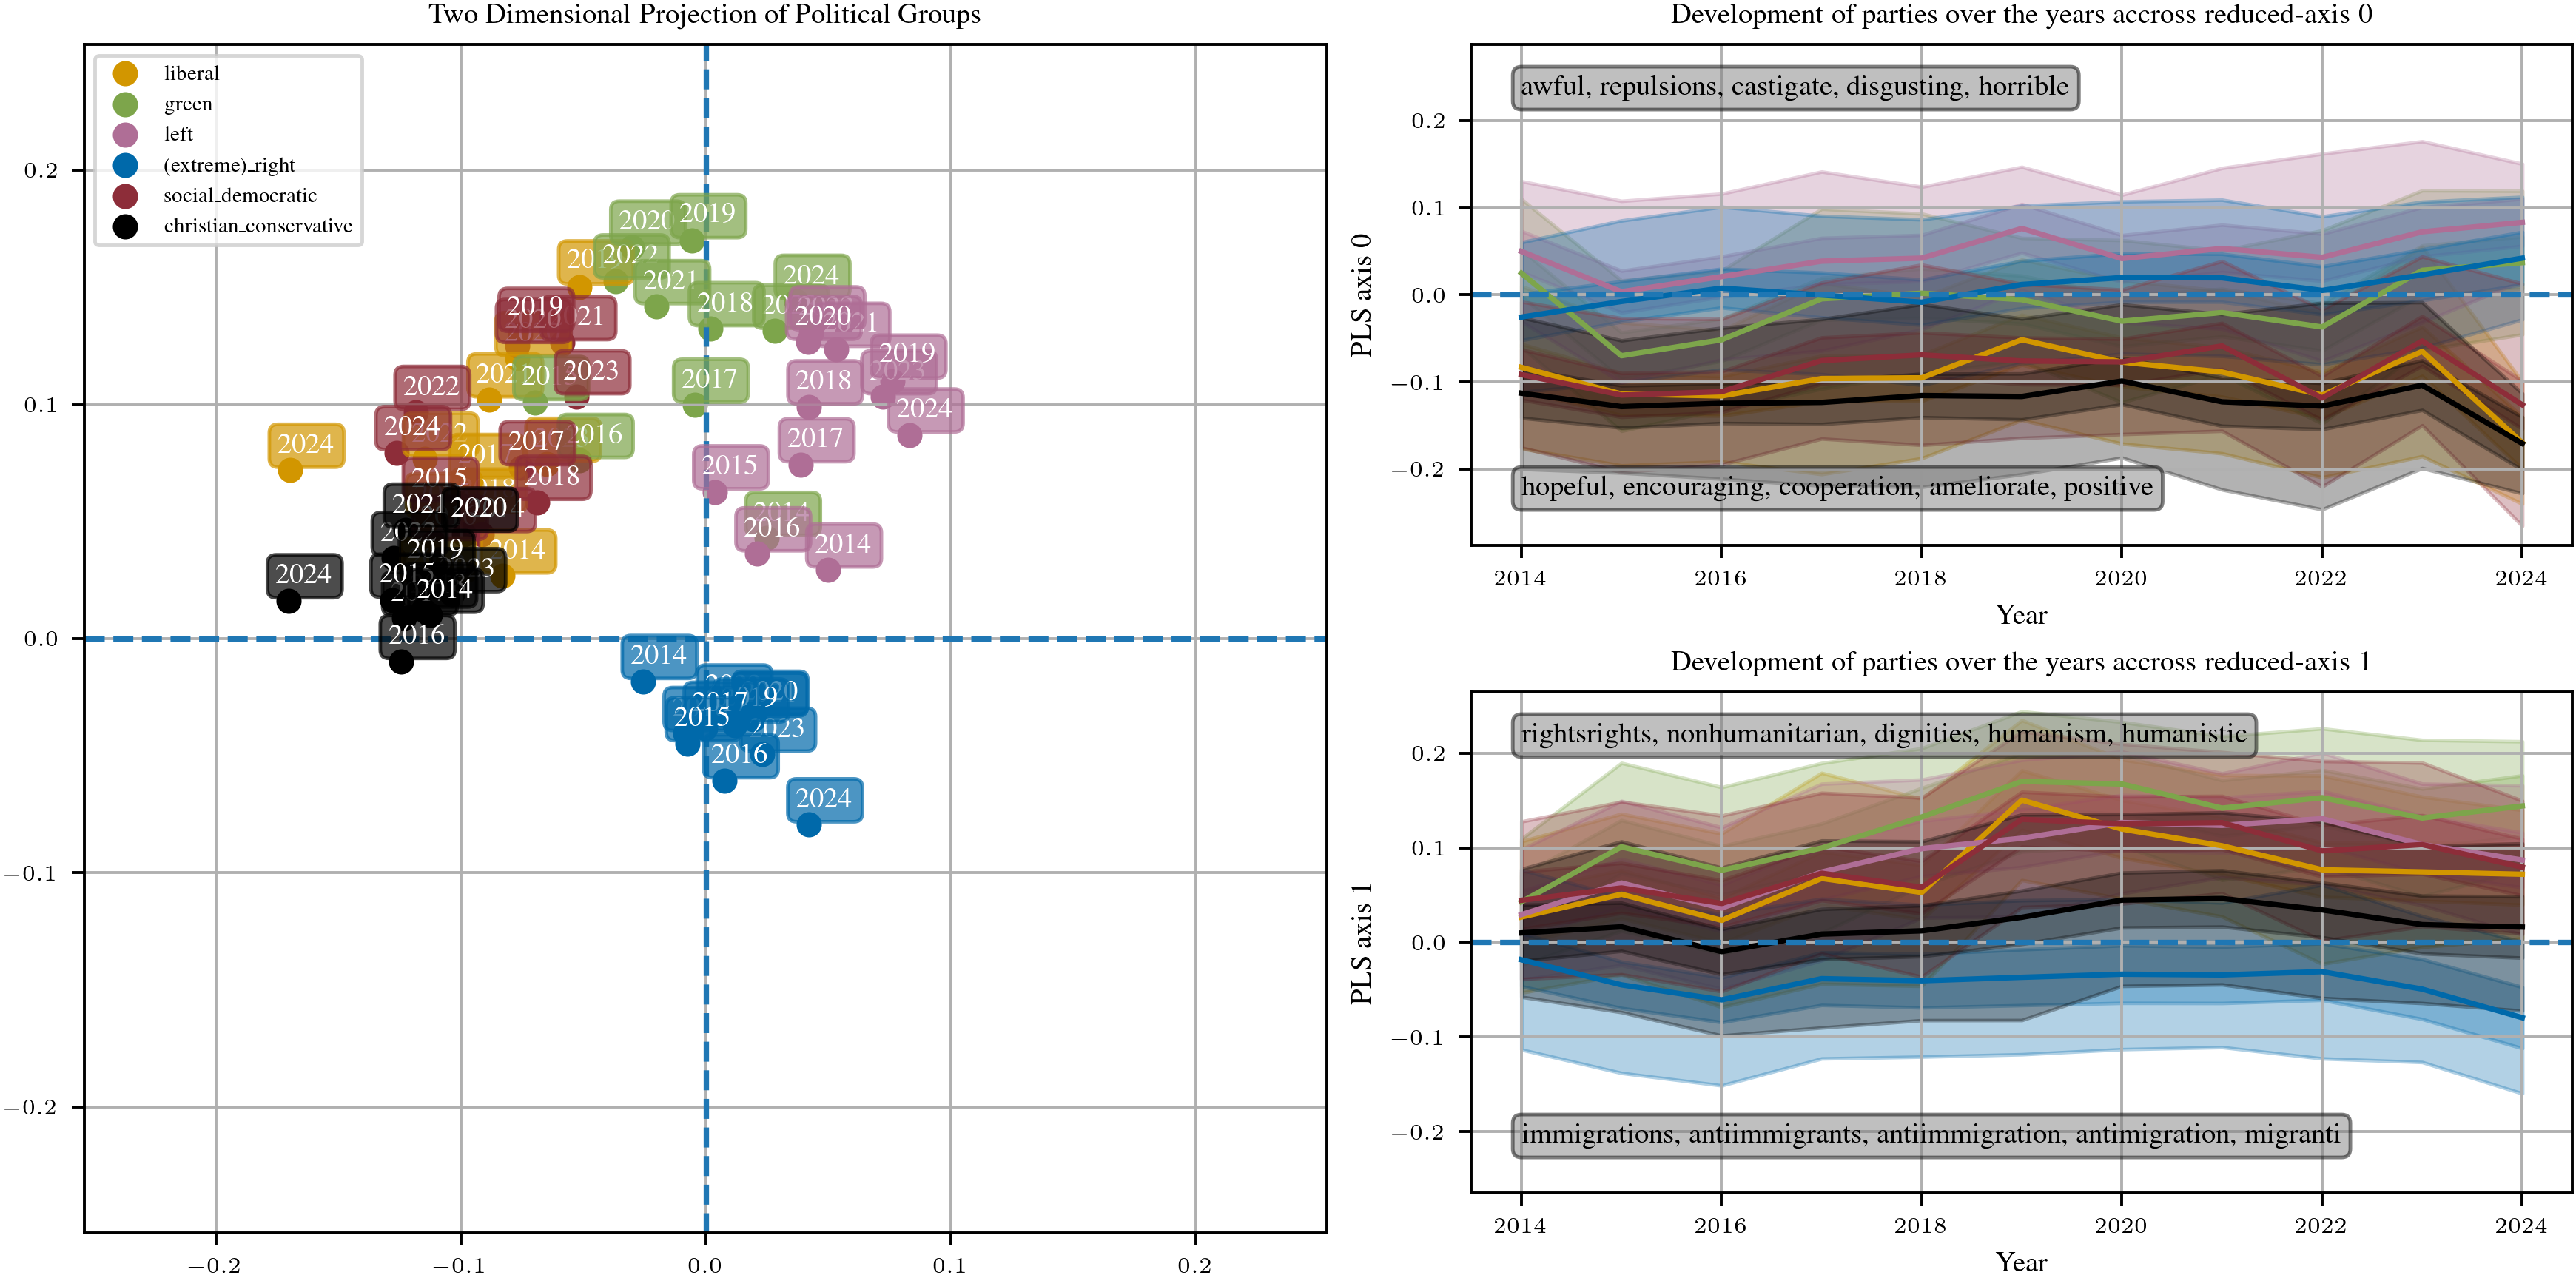

In [212]:
fig = plt.figure(layout="constrained", figsize=(10, 5))

gs0 = fig.add_gridspec(1, 2)
gs1 = gs0[1].subgridspec(2, 1)

ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs1[0])
ax3 = fig.add_subplot(gs1[1], sharex=ax2)

plot_scatter(ax1)
plot_axis(0, ax2, True)
plot_axis(1, ax3, True)